In [1]:
from utils import *
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
def plot_with_cbar(image,cmap="jet"):
    ax = plt.subplot()
    im=ax.imshow(image, cmap=cmap)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

    
def segment_table(points_data,zs_no_nans,obj_lMax=0.8):

    histogram, bin_edges =(np.histogram(zs_no_nans, bins=50))
    t = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
    trans=t.transform.translation.z
    print(trans)
    img_corrected = np.where((-zs_no_nans < trans*0.999) ,zs_no_nans,1.0)  #FLOOR

    #print((trans*0.999)-0.72 +0.2)
    #Quita a una altura
    plane_height= (trans)+bin_edges[histogram[:-1].argmax()+1]
    img_corrected = np.where(    (-zs_no_nans <  (trans*0.999)-plane_height-0.01),zs_no_nans,1)

    # Quita objetos lejanos
    lenZ_no_nans=np.where(~np.isnan(points_data['z']),points_data['z'],-5)
    lenZ_corrected=np.where(lenZ_no_nans<obj_lMax,lenZ_no_nans,-5)

    # quita Z en los que los X sean -5
    for r in range(img_corrected.shape[0]):
        for c in range(img_corrected.shape[1]):
            if lenZ_corrected[r,c]<=-5:
                img_corrected[r,c]=1
    return img_corrected
#-----------------------------------------------------    
def segment_floor(points_data,zs_no_nans,obj_hMax=0.85,obj_lMax=1.5):
    # obj_hMax -> altura maxima para objetos para segmentar
    # obj_lMax -> distancia de objetos maxima para segmentar

    # Quita piso y mayor a una cierta altura
    print("INIT")
    plot_with_cbar(zs_no_nans,cmap="gist_rainbow")
    
    t = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
    trans=t.transform.translation.z
    img_corrected = np.where((zs_no_nans < -obj_hMax),zs_no_nans,1)
    img_corrected = np.where((img_corrected >-trans-0.15),img_corrected,1)
    print("SIN PISO")
    plot_with_cbar(img_corrected,cmap="gist_rainbow")
    # Quita objetos lejanos
    ls_no_nans=np.where(~np.isnan(points_data['z']),points_data['z'],-5)
    print("LS de POINTS DATA sin nan")
    plot_with_cbar(ls_no_nans,cmap="gist_rainbow")
    lZ_corrected=np.where(ls_no_nans<obj_lMax,ls_no_nans,-5)
    print("SIN mayor que la distancia")
    plot_with_cbar(lZ_corrected,cmap="gist_rainbow")
    # Con esto, quita en z los que en X esten con -5
    for r in range(img_corrected.shape[0]):
        for c in range(img_corrected.shape[1]):
            if lZ_corrected[r,c]<=-5:
                img_corrected[r,c]=1

    return img_corrected

    
def plane_seg2(points_msg,hg=0.85,lg=1.5,lower=100 ,higher=50000,reg_ly= 30,reg_hy=600,plot=False):
    points_data = ros_numpy.numpify(points_msg)    
    image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
    image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
    image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print (image.shape)
    if plot:
        cv2.imshow("Image 1",rgb_image)
        cv2.waitKey(0)

        cv2.destroyAllWindows()

    _,corrected=correct_points(points_msg)
    zs_no_nans=np.where(~np.isnan(corrected['z']),corrected['z'],1)
    histogram, bin_edges =(np.histogram(zs_no_nans, bins=100))
    t = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
    trans=t.transform.translation.z
    plane_height= (trans)+bin_edges[histogram[:-1].argmax()+1]
    print(plane_height)
    if plane_height<0.1:
        print("Segmentacion en: Piso")
        im_corrected=segment_floor(points_data,zs_no_nans,obj_hMax=hg,obj_lMax=lg)
    else:
        print("Segmentacion en: Mesa")
        im_corrected=segment_table(points_data,zs_no_nans,obj_lMax=lg)
    
    if plot:
        cv2.imshow("Image to segment",im_corrected)
        cv2.waitKey(0)

        cv2.destroyAllWindows()
    contours, hierarchy = cv2.findContours(im_corrected.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    i=0
    cents=[]
    points=[]
    images=[]
    for i, contour in enumerate(contours):

        area = cv2.contourArea(contour)
        if area > lower and area < higher :
            M = cv2.moments(contour)
            # calculate x,y coordinate of center
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            if (cY > reg_ly and cY < reg_hy  ):

                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                #image_aux= iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
                

                image_aux= image[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[1]+boundRect[2]]
                images.append(image_aux)
                image_aux= im_corrected[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]

                mask=np.where(image_aux!=5)
                npmask=np.asarray(mask).T
                rgb_image=cv2.rectangle(rgb_image,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (255,255,0), 2)
                cv2.circle(rgb_image, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(rgb_image, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 255, 0), 2)
                print ('cX,cY',cX,cY,'len mask',len(npmask))
                xyz=[]
                if len (npmask)>0:
                    for a in npmask:
                        ix,iy=a[0],a[1]
                        aux=(np.asarray((points_data['x'][boundRect[1]+ix,boundRect[0]+iy],points_data['y'][boundRect[1]+ix,boundRect[0]+iy],points_data['z'][boundRect[1]+ix,boundRect[0]+iy])))
                        #print (aux)
                        if np.isnan(aux[0]) or np.isnan(aux[1]) or np.isnan(aux[2]):
                                'reject point'
                        else:
                            xyz.append(aux)
                
                xyz=np.asarray(xyz)
                #print (xyz)
                cent=xyz.mean(axis=0)
                cents.append(cent)
                print (cent)
                points.append(xyz)
                
            else:   
                print ('cent out of region... rejected')
    return cents,np.asarray(points), images,rgb_image


In [5]:
points_msg=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2,timeout=5)



(480, 640, 3)
-0.0815459935189704
Segmentacion en: Piso
INIT


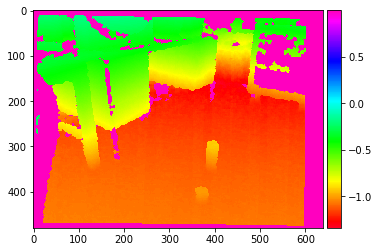

SIN PISO


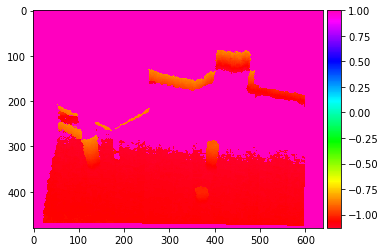

LS de POINTS DATA sin nan


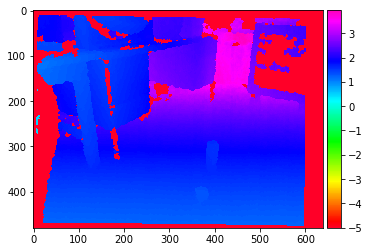

SIN mayor que la distancia


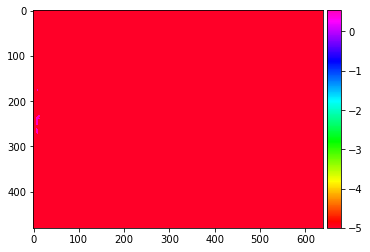

In [6]:

cents,xyz, images, img = plane_seg2(points_msg,hg=0.85,lg=0.7,lower=700, higher=6000,reg_hy=350,plot=False)


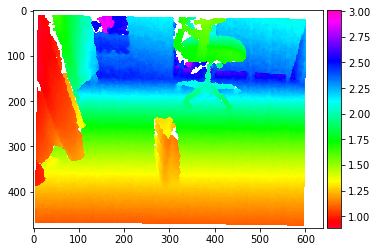

In [10]:
plot_with_cbar(points_data['z'],cmap="gist_rainbow")

Piso
Imagen de entrada


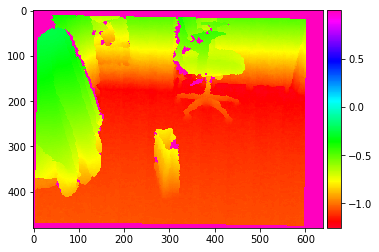

Salida, en Z sin datos en Y mayores que 1.5


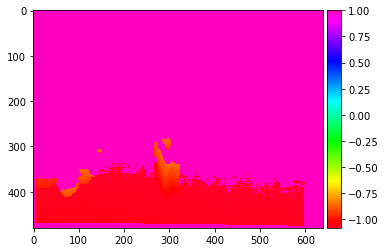

In [21]:
im_corrected=segment(corrected,op=0)

In [24]:
lower=900
higher=200000
reg_ly= 30
reg_hy=600
contours, hierarchy = cv2.findContours(im_corrected.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
i=0
cents=[]
points=[]
images=[]
for i, contour in enumerate(contours):

    area = cv2.contourArea(contour)
    if area > lower and area < higher :
        M = cv2.moments(contour)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        if (cY > reg_ly and cY < reg_hy  ):

                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                #image_aux= iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
                

                image_aux= image[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[1]+boundRect[2]]
                images.append(image_aux)
                image_aux= im_corrected[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]

                mask=np.where(image_aux!=5)
                npmask=np.asarray(mask).T
                hsv_image=cv2.rectangle(hsv_image,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
                cv2.circle(hsv_image, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(hsv_image, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY,'len mask',len(npmask))
                

cX,cY 26 380 len mask 1479
cX,cY 294 354 len mask 6649


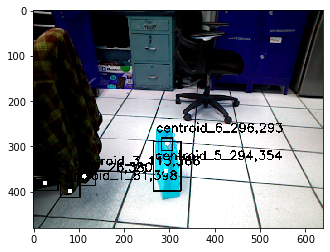

In [25]:
plt.imshow(hsv_image)

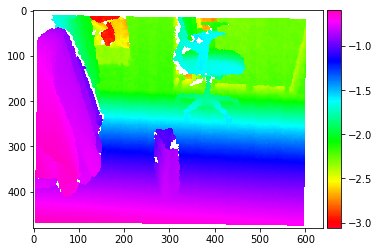

In [26]:
plot_with_cbar(corrected['y'],cmap="gist_rainbow")

## PRUEBAS POR PARTES

In [ ]:
zs_no_nans=np.where(~np.isnan(corrected['z']),corrected['z'],1)

In [ ]:
plot_with_cbar(zs_no_nans,cmap="gist_rainbow")

In [ ]:
histogram, bin_edges =(np.histogram(zs_no_nans, bins=50))
plt.plot(bin_edges[0:-1], histogram)  

In [ ]:
histogram[:-1].argmax(), bin_edges[histogram[:-1].argmax()]

In [ ]:
t = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
trans=t.transform.translation.z
print(trans)

In [ ]:

img_corrected = np.where((zs_no_nans < -0.85),zs_no_nans,1)
img_corrected = np.where((img_corrected >-trans-0.1),img_corrected,1)

In [ ]:
plot_with_cbar(img_corrected,cmap="gist_rainbow")

In [ ]:
# Quitando lejanos
ys_no_nans=np.where(~np.isnan(corrected['y']),corrected['y'],-5)
y_corrected=np.where(ys_no_nans>-1.5,ys_no_nans,-5)

In [ ]:
plot_with_cbar(ys_no_nans,cmap="gist_rainbow")

In [ ]:
plot_with_cbar(y_corrected,cmap="gist_rainbow")

In [ ]:
img_corrected=np.where(ys_no_nans>-1.5,ys_no_nans,1)

In [ ]:
plot_with_cbar(img_corrected,cmap="gist_rainbow")

In [ ]:
lower=100
higher=200000
reg_ly= 30
reg_hy=600
contours, hierarchy = cv2.findContours(img_corrected.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
i=0
cents=[]
points=[]
images=[]
for i, contour in enumerate(contours):

    area = cv2.contourArea(contour)
    if area > lower and area < higher :
        M = cv2.moments(contour)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        if (cY > reg_ly and cY < reg_hy  ):

                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                #image_aux= iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
                

                image_aux= image[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[1]+boundRect[2]]
                images.append(image_aux)
                image_aux= img_corrected[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]

                mask=np.where(image_aux!=5)
                npmask=np.asarray(mask).T
                hsv_image=cv2.rectangle(hsv_image,(boundRect[0], boundRect[1]),
                                        (boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (51, 255, 255), 2)
                cv2.circle(hsv_image, (cX, cY), 5, (51, 255, 255), -1)
                cv2.putText(hsv_image, "centroid_"+str(i)+"_"+str(cX)+','+str(cY),(cX - 25, cY - 25),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.9, (51, 255, 255), 2)
                print ('cX,cY',cX,cY,'len mask',len(npmask))
                

In [ ]:
plt.imshow(hsv_image)

In [ ]:
def read_yaml(known_locations_file = '/known_locations.yaml'):
    rospack = rospkg.RosPack()
    file_path = rospack.get_path('config_files')  + known_locations_file

    with open(file_path, 'r') as file:
        content = yaml.safe_load(file)
    return content

In [ ]:
con=read_yaml()

In [ ]:
con

In [1]:
import rospkg

In [2]:
import yaml

In [3]:
def read_yaml(known_locations_file = '/known_locations.yaml'):
    rospack = rospkg.RosPack()
    file_path = rospack.get_path('location_reacher') +'/config_files' + known_locations_file

    with open(file_path, 'r') as file:
        content = yaml.safe_load(file)
    return content

In [5]:
con=read_yaml()
con

{'living_room': [{'x': 10.04},
  {'y': -1.86},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.72},
  {'qw': -0.7}],
 'dining_room': [{'x': 9.66},
  {'y': -3.85},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.68},
  {'qw': -0.74}],
 'kitchen': [{'x': 7.3},
  {'y': -2.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.7},
  {'qw': 0.71}],
 'bedroom': [{'x': 5.12},
  {'y': -2.41},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.7},
  {'qw': 0.71}],
 'entrance': [{'x': 1.34},
  {'y': -4.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': -0.01},
  {'qw': -1.0}],
 'corridor': [{'x': 6.62},
  {'y': -4.11},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': -1.0}],
 'cassette_demo': [{'x': 10.45},
  {'y': -1.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.07},
  {'qw': 1.0}],
 'doc_goal_1': [{'x': 4.87},
  {'y': -3.33},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': 1.0}],
 'd

In [ ]:
yaml.safe_load(file)

In [ ]:
file_path = rospack.get_path('location_reacher') +'/config_files' + known_locations_file

In [ ]:
known_locations_file = '/known_locations.yaml'
rospack = rospkg.RosPack()
file_path = rospack.get_path('location_reacher') +'/config_files' + known_locations_file
with open(file_path, 'r') as file:
        df = pd.json_normalize(safe_load(f))

    

In [ ]:
import pandas as pd

In [ ]:
df= pd.DataFrame.from_dict(con)

In [ ]:
df

In [ ]:
df['new_loc']= df['living_room']

In [ ]:
df['new_loc'][0]['x']    = 0.0
df['new_loc'][1]['y']    = 0.0
df['new_loc'][2]['theta']= 0.0
df['new_loc'][3]['qx']= 0.0
df['new_loc'][4]['qy']= 0.0
df['new_loc'][5]['qz']= 0.0
df['new_loc'][6]['qw']= 0.0

In [ ]:
df

In [ ]:
with open('test_df_yaml.yaml', 'w') as file:
    documents = yaml.dump({'result': df.to_dict()}, file, default_flow_style=False)

In [18]:
con=read_yaml('/test_df_yaml.yaml')
con

{'bedroom': [{'x': 5.12},
  {'y': -2.41},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.7},
  {'qw': 0.71}],
 'cassette_demo': [{'x': 10.45},
  {'y': -1.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.07},
  {'qw': 1.0}],
 'corridor': [{'x': 6.62},
  {'y': -4.11},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': -1.0}],
 'dining_room': [{'x': 9.66},
  {'y': -3.85},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.68},
  {'qw': -0.74}],
 'doc_goal_1': [{'x': 4.87},
  {'y': -3.33},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': 1.0}],
 'doc_goal_2': [{'x': 5.53},
  {'y': -2.61},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': 1.0}],
 'entrance': [{'x': 1.34},
  {'y': -4.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': -0.01},
  {'qw': -1.0}],
 'kitchen': [{'x': 7.3},
  {'y': -2.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.7},
  {'qw': 0.71}],
 'livin

In [20]:
data= deepcopy(con[list(con.keys())[0]])

data[0]['x']=1
data[1]['y']=1
data[2]['theta']=1
data[3]['qx']=1
data[4]['qy']=1
data[5]['qz']=1
data[6]['qw']=1


In [21]:
data

[{'x': 1}, {'y': 1}, {'theta': 1}, {'qx': 1}, {'qy': 1}, {'qz': 1}, {'qw': 1}]

In [22]:
con['new']=data

In [23]:
con

{'bedroom': [{'x': 5.12},
  {'y': -2.41},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.7},
  {'qw': 0.71}],
 'cassette_demo': [{'x': 10.45},
  {'y': -1.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.07},
  {'qw': 1.0}],
 'corridor': [{'x': 6.62},
  {'y': -4.11},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': -1.0}],
 'dining_room': [{'x': 9.66},
  {'y': -3.85},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.68},
  {'qw': -0.74}],
 'doc_goal_1': [{'x': 4.87},
  {'y': -3.33},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': 1.0}],
 'doc_goal_2': [{'x': 5.53},
  {'y': -2.61},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': 1.0}],
 'entrance': [{'x': 1.34},
  {'y': -4.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': -0.01},
  {'qw': -1.0}],
 'kitchen': [{'x': 7.3},
  {'y': -2.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.7},
  {'qw': 0.71}],
 'livin

In [24]:
data

[{'x': 1}, {'y': 1}, {'theta': 1}, {'qx': 1}, {'qy': 1}, {'qz': 1}, {'qw': 1}]

In [27]:
with open('test_df_yaml.yaml', 'w') as file:
    documents = yaml.dump(con, file, default_flow_style=False)

In [26]:
con

{'bedroom': [{'x': 5.12},
  {'y': -2.41},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.7},
  {'qw': 0.71}],
 'cassette_demo': [{'x': 10.45},
  {'y': -1.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.07},
  {'qw': 1.0}],
 'corridor': [{'x': 6.62},
  {'y': -4.11},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': -1.0}],
 'dining_room': [{'x': 9.66},
  {'y': -3.85},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.68},
  {'qw': -0.74}],
 'doc_goal_1': [{'x': 4.87},
  {'y': -3.33},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': 1.0}],
 'doc_goal_2': [{'x': 5.53},
  {'y': -2.61},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.0},
  {'qw': 1.0}],
 'entrance': [{'x': 1.34},
  {'y': -4.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': -0.01},
  {'qw': -1.0}],
 'kitchen': [{'x': 7.3},
  {'y': -2.6},
  {'theta': 0.0},
  {'qx': 0.0},
  {'qy': 0.0},
  {'qz': 0.7},
  {'qw': 0.71}],
 'livin

In [17]:
with open('test_df_yaml.yaml', 'w') as file:
    documents = yaml.dump(con, file, default_flow_style=False)

In [ ]:
rospack = rospkg.RosPack()

rospack.get_path('config_files')

In [ ]:
def read_yaml(known_locations_file = '/known_locations.yaml'):
    rospack = rospkg.RosPack()
    file_path = rospack.get_path('config_files')  + known_locations_file

    with open(file_path, 'r') as file:
        content = yaml.safe_load(file)
    return content

In [ ]:
con = read_yaml()

In [ ]:
data= con['entrance'][0]

In [ ]:
type(data)

In [ ]:
data['x']

In [ ]:
import pandas as pd

In [ ]:
df=pd.DataFrame(con)

In [ ]:
data.values()

In [ ]:
a=df['living_room'].iloc[].values()

In [ ]:
import numpy as np


In [ ]:

def yaml_to_df():
    con = read_yaml()
    values=[]
    locations=[]
    for c in con:
        locations.append(c)

        for i in range(len(con[c])):
            values.append(list(con[c][i].values())[0])

    data=np.asarray(values).reshape((int(len(values)/7),7))
    df= pd.DataFrame( data)
    df.columns=['x','y','th','qx','qy','qz','qw']
    df['child_id_frame']=locations
    return df

In [ ]:
df = yaml_to_df()


In [ ]:
df

In [ ]:
df['child_id_frame']

In [ ]:
df['x']

In [ ]:
df

In [ ]:
len(df)

In [ ]:
df.columns

In [ ]:
df['x']

In [ ]:
import math